<a href="https://colab.research.google.com/github/anhbui5302/nanoGPT/blob/master/examples/classifier_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifier Finetune

In [8]:
# Install required libraries
!pip install -q -U transformers datasets accelerate peft bitsandbytes scikit-learn unsloth

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.8/184.8 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/129.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 16.8 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!apt install git-lfs

In [4]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import AutoTokenizer
import numpy as np

# --- 1. Load your .jsonl data ---
# This part remains the same.
relevant_path = '/content/drive/MyDrive/classifier_finetune/training_data_relevant_unique_500.jsonl'
irrelevant_path = '/content/drive/MyDrive/classifier_finetune/training_data_irrelevant_unique_500.jsonl'

relevant_dataset = load_dataset('json', data_files=relevant_path, split='train')
irrelevant_dataset = load_dataset('json', data_files=irrelevant_path, split='train')

# --- 2. Combine and shuffle the data ---
# This part remains the same.
full_dataset = concatenate_datasets([relevant_dataset, irrelevant_dataset])
full_dataset = full_dataset.shuffle(seed=42)

# --- 3. Split the data into training and testing sets ---
# We split the raw data first.
final_datasets = full_dataset.train_test_split(test_size=0.1)


# --- 4. Load the tokenizer ---
# The tokenizer is needed to apply the model's specific chat template.
# Note: This will be loaded again by Unsloth, which is fine. We need it here for formatting.
model_checkpoint = "google/gemma-3-1b-it"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


# --- 5. Format the dataset using the official chat template ---
def format_chat_template(example):
    # The history and context are formatted as a single "user" turn.
    messages = [
        {
            "role": "user",
            "content": (
                "Classify the user's message as RELEVANT or IRRELEVANT to the math problem and conversation history.\n\n"
                "### MATH PROBLEM\n"
                f"Problem: {example['context']['problem']}\n"
                f"Solution: {example['context']['solution']}\n\n"
                "### CONVERSATION HISTORY\n" +
                "".join(
                    f"{'AI Tutor' if msg['role'] == 'ai' else 'Student'}: {msg['content']}\n"
                    for msg in example['history']
                ) + "\n"
                "### USER MESSAGE\n"
                f"{example['user_message']}"
            )
        },
        # The assistant's label is the response it is being taught to generate.
        {
            "role": "assistant",
            "content": example['label']
        }
    ]
    # The tokenizer handles adding all the special tokens like '<start_of_turn>' and '<end_of_turn>'.
    # We create a new column called "text" which contains the fully formatted string.
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)}

# Apply the new formatting function to our datasets.
# Unsloth will handle the tokenization internally during training.
formatted_datasets = final_datasets.map(format_chat_template)

# --- 6. Verify the new format ---
# We print the output to see the result of the new formatting.
print("Training set size:", len(formatted_datasets['train']))
print("Test set size:", len(formatted_datasets['test']))
print("\nExample of a formatted prompt from the 'text' column:")
print(formatted_datasets['train'][0]['text'])

# The 'formatted_datasets' object is now ready to be passed directly into the Trainer.
# Make sure to use dataset_text_field="text" in your Trainer arguments.

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Training set size: 900
Test set size: 100

Example of a formatted prompt from the 'text' column:
<bos><start_of_turn>user
Classify the user's message as RELEVANT or IRRELEVANT to the math problem and conversation history.

### MATH PROBLEM
Problem: <div class="question" role=region aria-label="Question">
Factor the expression.<br />
` x^3 -  x^2 + 23 x - 23=` <input type="text" size="20" name="qn27" id="qn27" value="" autocomplete="off" aria-label="Question 28" class="text" /><span id=p27></span>

<br /><br/><br/>

</div>
Solution: Step 1: Split the expression into two separate expressions.<br/>
 It gives us `(x^3 -1 x^2) + (23 x -23)`.<br/><br/>
Step 2: The GCF of the first expression is `x^2`.<br/>
The GCF of the second expression is `23`.<br/><br/>
Step 2: Factor out the GCF of each expression separately.<br/>
 It gives us, `x^2(x -1) + 23( x -1)`<br/><br/>
Step 3: The GCF of  `x^2(x -1)` and  `23( x -1)` is `( x -1)`.<br/><br/>
Step 4: Factor out `( x -1)` gives us the factored for

Analyzing the training set:


Map (num_proc=4):   0%|          | 0/900 [00:00<?, ? examples/s]

--- Token Length Analysis ---
Total examples: 900
Min token length:    151
Max token length:    20304
Mean token length:   853.23
Median token length: 634.5

--- Percentiles ---
90th percentile: 1346
95th percentile: 1832
99th percentile: 5702
-----------------------------

This analysis helps you choose an optimal `max_seq_length`.
Your current max_seq_length is set to 512.
Examples longer than this will be truncated.
-----------------------------


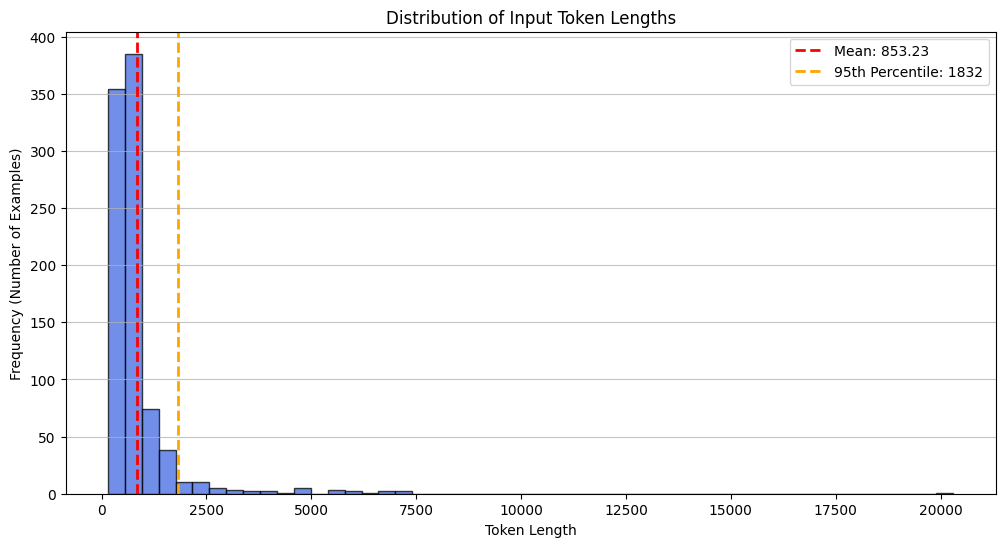


Analyzing the test set:


Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

--- Token Length Analysis ---
Total examples: 100
Min token length:    317
Max token length:    5923
Mean token length:   933.57
Median token length: 655.0

--- Percentiles ---
90th percentile: 1233
95th percentile: 2663
99th percentile: 5872
-----------------------------

This analysis helps you choose an optimal `max_seq_length`.
Your current max_seq_length is set to 512.
Examples longer than this will be truncated.
-----------------------------


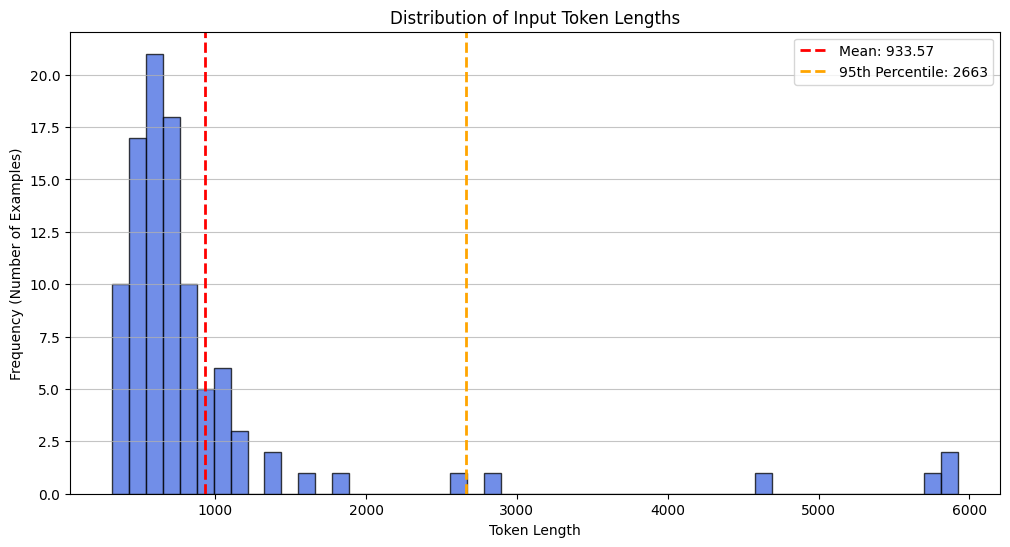

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_token_lengths(dataset, tokenizer, text_column="text"):
    """
    Calculates, prints statistics, and plots the distribution of token lengths
    for a given Hugging Face dataset.

    Args:
        dataset (datasets.Dataset): The dataset to analyze (e.g., formatted_datasets['train']).
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer for converting text to tokens.
        text_column (str): The name of the column in the dataset that contains the text.
    """
    # Use the efficient .map() function to tokenize and get the length of each input
    # This is much faster than iterating through the dataset in a loop.
    token_lengths = dataset.map(
        lambda example: {'length': len(tokenizer(example[text_column]).input_ids)},
        num_proc=4  # Use multiple processes to speed up the calculation
    )['length']

    token_lengths = np.array(token_lengths)

    # --- Calculate and Print Statistics ---
    print("--- Token Length Analysis ---")
    print(f"Total examples: {len(token_lengths)}")
    print(f"Min token length:    {np.min(token_lengths)}")
    print(f"Max token length:    {np.max(token_lengths)}")
    print(f"Mean token length:   {np.mean(token_lengths):.2f}")
    print(f"Median token length: {np.median(token_lengths)}")
    print("\n--- Percentiles ---")
    print(f"90th percentile: {np.percentile(token_lengths, 90):.0f}")
    print(f"95th percentile: {np.percentile(token_lengths, 95):.0f}")
    print(f"99th percentile: {np.percentile(token_lengths, 99):.0f}")
    print("-" * 29)
    print(f"\nThis analysis helps you choose an optimal `max_seq_length`.")
    print(f"Your current max_seq_length is set to 512.")
    print(f"Examples longer than this will be truncated.")
    print("-" * 29)


    # --- Plot the Histogram ---
    plt.figure(figsize=(12, 6))
    plt.hist(token_lengths, bins=50, alpha=0.75, color='royalblue', edgecolor='black')
    plt.axvline(np.mean(token_lengths), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(token_lengths):.2f}')
    plt.axvline(np.percentile(token_lengths, 95), color='orange', linestyle='dashed', linewidth=2, label=f'95th Percentile: {np.percentile(token_lengths, 95):.0f}')
    plt.title('Distribution of Input Token Lengths')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency (Number of Examples)')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# --- Example of how to call the function ---
# Make sure this is placed AFTER you have created your `formatted_datasets`
# and loaded your `tokenizer`.

print("Analyzing the training set:")
analyze_token_lengths(formatted_datasets['train'], tokenizer)

print("\nAnalyzing the test set:")
analyze_token_lengths(formatted_datasets['test'], tokenizer)

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return logits.argmax(dim=-1)

# Using your preferred, explicit metric calculation
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels[labels == -100] = tokenizer.pad_token_id
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    decoded_preds = [pred if pred else "__empty__" for pred in decoded_preds] # Handle empty predictions

    # Use the individual score functions as you requested
    precision = precision_score(decoded_labels, decoded_preds, average='binary', pos_label='RELEVANT', zero_division=0)
    recall = recall_score(decoded_labels, decoded_preds, average='binary', pos_label='RELEVANT', zero_division=0)
    f1 = f1_score(decoded_labels, decoded_preds, average='binary', pos_label='RELEVANT', zero_division=0)
    acc = accuracy_score(decoded_labels, decoded_preds)

    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [13]:
import torch
import unsloth
import numpy as np
from transformers import AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset, concatenate_datasets
from trl import SFTTrainer


model, tokenizer = unsloth.FastLanguageModel.from_pretrained(
    model_name = model_checkpoint,
    max_seq_length = 512,
    dtype = None, # Will auto-detect torch.bfloat16 if available
    load_in_4bit = True,
)

model = unsloth.FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_alpha = 32,
    lora_dropout = 0.05,
    bias = "none",
    task_type = "CAUSAL_LM",
)
model.print_trainable_parameters()

model_name = model_checkpoint.split("/")[-1]
# Training Arguments
training_args = TrainingArguments(
    output_dir=f"{model_name}-classifier-finetune",
    num_train_epochs=3,
    per_device_train_batch_size = 1,  # We can likely go back to 2 now!
    gradient_accumulation_steps = 16, # Effective batch size is still 16
    gradient_checkpointing = True,   # Keep this for extra safety
    optim="adamw_8bit", # Unsloth works great with 8bit optimizers
    learning_rate=2e-4,
    logging_steps=25,
    fp16 = not torch.cuda.is_bf16_supported(), # Use bf16 if available, else fp16
    bf16 = torch.cuda.is_bf16_supported(),
    push_to_hub=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=formatted_datasets["train"],
    eval_dataset=formatted_datasets["test"],
    dataset_text_field="text",
    max_seq_length=512,
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics,
    # preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)

==((====))==  Unsloth 2025.8.9: Fast Gemma3 patching. Transformers: 4.55.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Making `model.base_model.model.model` require gradients
trainable params: 2,981,888 || all params: 1,002,867,840 || trainable%: 0.2973
Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"]:   0%|          | 0/100 [00:00<?, ? examples/s]

In [14]:
# Start training!
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 900 | Num Epochs = 3 | Total steps = 171
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 2,981,888 of 1,002,867,840 (0.30% trained)


Epoch,Training Loss,Validation Loss
1,1.142500,1.074784
2,1.045900,1.049390
3,1.008200,1.036741


TrainOutput(global_step=171, training_loss=1.1290845034415262, metrics={'train_runtime': 1329.3603, 'train_samples_per_second': 2.031, 'train_steps_per_second': 0.129, 'total_flos': 7549145206944768.0, 'train_loss': 1.1290845034415262})

In [15]:
eval_results = trainer.evaluate()


In [16]:
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 1.036740779876709, 'eval_runtime': 18.4885, 'eval_samples_per_second': 5.409, 'eval_steps_per_second': 5.409}
